## **Starting Code - Libraries**

In [25]:
!pip install obspy

In [26]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import obspy
from obspy.signal.detrend import polynomial
from scipy.signal import find_peaks

## **Load the data**

In [27]:
data_path = 'VideoFullTest.csv'
plt.rcParams.update({'font.size': 11})

# Arrays using for storing the raw data from the CSV file
bpm_raw   = []
aux_raw   = []
bpm_time  = []
aux_time  = []
ppg_raw   = []
ppg_time  = []
ecg_raw   = []
ecg_time  = []

# Flag used for skipping the header in the data file
header = True

# Variables for keeping the start and stop time for the BPM
t_start = 0
t_stop  = 0

t_dia_ppg = 0
t_sys_aux = 0
t_dia_bpm = 0
t_sys_bpm = 0

hr_ppg = 0
hr_aux = 0
hr_bpm = 0

# Getting the data out of the file and into the variables
with open(data_path, 'r', newline = '') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        if header == True:
            header = False
        else:
            if row[0] != '':
              ecg_raw.append(int(row[0]))
              ecg_time.append(int(row[1]))
            if row[2] != '':
              bpm_raw.append(float(row[2]))
              bpm_time.append(int(row[3]))
            if row[4] != '':
              aux_raw.append(int(row[4]))
              aux_time.append(int(row[5]))
            if row[6] != '':
              ppg_raw.append(int(row[6]))
              ppg_time.append(int(row[7]))

st_time = ecg_time[0]
ecg_time = [(ecg_time[i] - st_time) / 1000.00 for i in range(len(ecg_time))]
st_time = bpm_time[0]
bpm_time = [(bpm_time[i] - st_time) / 1000.00 for i in range(len(bpm_time))]
st_time = aux_time[0]
aux_time = [(aux_time[i] - st_time) / 1000.00 for i in range(len(aux_time))]
st_time = ppg_time[0]
ppg_time = [(ppg_time[i] - st_time) / 1000.00 for i in range(len(ppg_time))]

# **Pressure Signal**

## **Full Measurement**

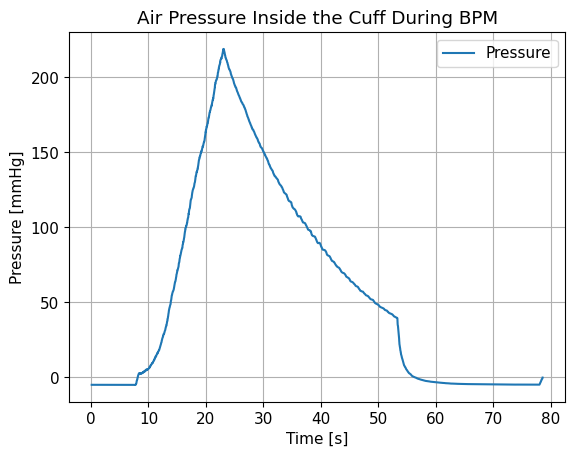

In [28]:
# Filtering the pressure signal my moving an average window across the data
window_size = 35
bpm_filtered_data = []
bpm_filtered_time = []
for i in range(window_size, len(bpm_raw)):
  bpm_filtered_data.append(sum(bpm_raw[i : i + window_size]) / window_size)
bpm_filtered_time = bpm_time[window_size :]

# Figure 1 - Pressure signal during the whole pressure measurement
fig_bpm1, ax_bpm1 = plt.subplots()
ax_bpm1.plot(bpm_filtered_time[0 :], bpm_filtered_data[0 :], label = 'Pressure')
ax_bpm1.set(xlabel = 'Time [s]', ylabel = 'Pressure [mmHg]', title = 'Air Pressure Inside the Cuff During BPM')
ax_bpm1.legend()
ax_bpm1.grid(which='both')

## **Deflation Segment**

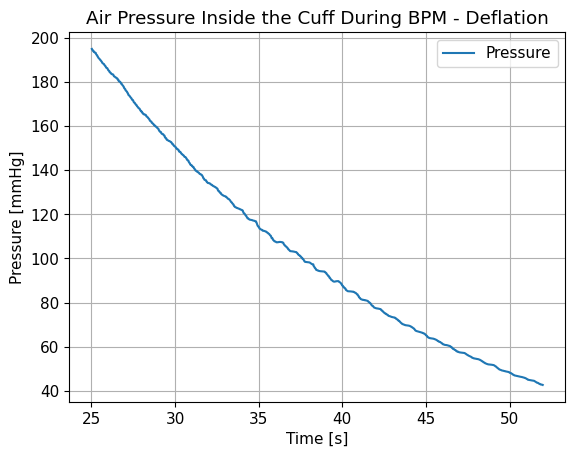

In [29]:
# Deflation bpm signals
t_deflation_start = 25
t_deflation_stop  = 52
bpm_deflation_data = []
bpm_deflation_time = []
# Extracting the deflation part of the BPM signals
for i in range(0, len(bpm_filtered_data)):
    if bpm_filtered_time[i] >= t_deflation_start and bpm_filtered_time[i] <= t_deflation_stop:
      bpm_deflation_data.append(bpm_filtered_data[i])
      bpm_deflation_time.append(bpm_filtered_time[i])

# Figure 2 - Pressure signal during the deflation portion of the measurement
fig_bpm2, ax_bpm2 = plt.subplots()
ax_bpm2.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pressure')
ax_bpm2.set(xlabel = 'Time [s]', ylabel = 'Pressure [mmHg]', title = 'Air Pressure Inside the Cuff During BPM - Deflation')
ax_bpm2.legend()
ax_bpm2.grid(which='both')

## **Detrending the Data**

/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/obspy/signal/detrend.py:110: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyval(np.polyfit(x, data, deg=order), x)


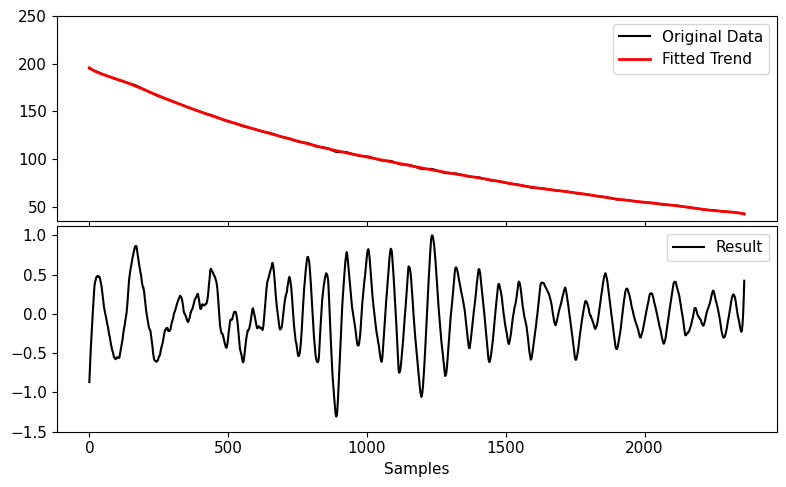

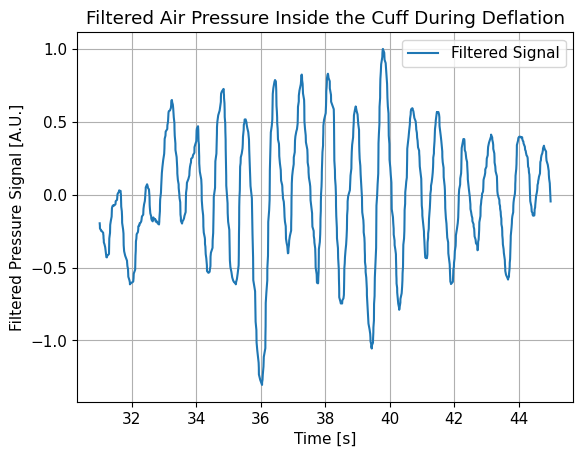

In [30]:
# Detrending the pressure function
obspy_data = obspy.read()[0].filter('highpass', freq = 1)
obspy_data.data = np.array(bpm_deflation_data)
trend_data = obspy_data.data
trend_function = polynomial(trend_data, order = 50, plot = True)

t_bpm_analysis_start  = 27.5
t_bpm_analysis_stop   = 47.5
t_bpm_analysis_start  = 31
t_bpm_analysis_stop   = 45
bpm_analysis_data     = []
bpm_analysis_time     = []

for i in range(0, len(bpm_deflation_time)):
  if bpm_deflation_time[i] >= t_bpm_analysis_start and bpm_deflation_time[i] <= t_bpm_analysis_stop:
    bpm_analysis_data.append(trend_function[i])
    bpm_analysis_time.append(bpm_deflation_time[i])

# Figure 3 - Detrended pressure signal during the deflation portion of the measurement
fig_bpm3, ax_bpm3 = plt.subplots()
ax_bpm3.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtered Signal')
ax_bpm3.set(xlabel = 'Time [s]', ylabel = 'Filtered Pressure Signal [A.U.]', title = 'Filtered Air Pressure Inside the Cuff During Deflation')
ax_bpm3.legend()
ax_bpm3.grid(which='both')

## **Peak Detection**

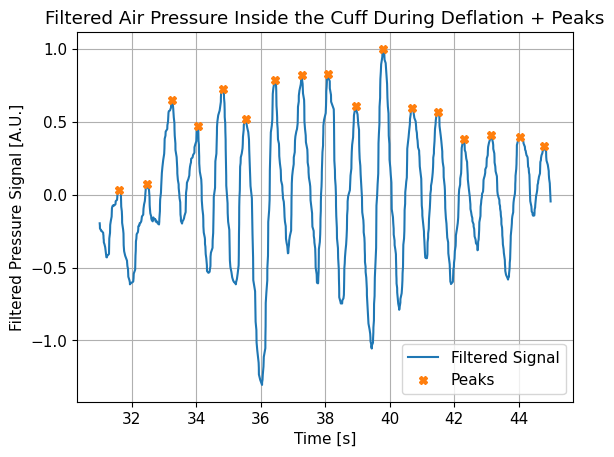

In [31]:
# Pressure Signal Peak Detection
bpm_peaks_ids, aux_peak_properties = find_peaks(bpm_analysis_data, height = -0.1, distance = 10, prominence = (0.2, None))
bpm_peaks_data = []
bpm_peaks_time = []
# Saving the found peaks to arrazs
for peak in bpm_peaks_ids:
  bpm_peaks_data.append(bpm_analysis_data[peak])
  bpm_peaks_time.append(bpm_analysis_time[peak])

# Figure 4 - Detrended pressure signal with peak detection
fig_bpm4, ax_bpm4 = plt.subplots()
ax_bpm4.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtered Signal')
ax_bpm4.plot(bpm_peaks_time, bpm_peaks_data, 'X', label = 'Peaks')
ax_bpm4.set(xlabel = 'Time [s]', ylabel = 'Filtered Pressure Signal [A.U.]', title = 'Filtered Air Pressure Inside the Cuff During Deflation + Peaks')
ax_bpm4.legend(loc = 4)
ax_bpm4.grid(which='both')

## **Envelope Estimation**

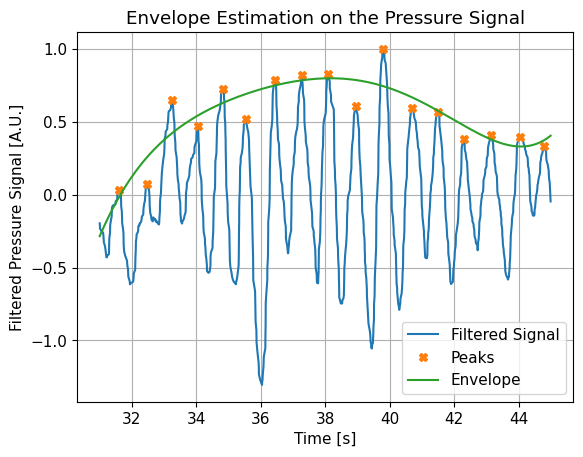

In [32]:
# Estimated Signal Envlope
# Polynomial fit on the peaks
bpm_envelope_coefs = np.polyfit(bpm_peaks_time, bpm_peaks_data, deg = 5)
bpm_envelope = []
# Calculating the signal based on the polyfit coefs
for i in range(0, len(bpm_analysis_time)):
  dot = 1
  val = 0
  # Calculate the envelope point using all of the coefficients
  for j in range(0, len(bpm_envelope_coefs)):
    val += dot * bpm_envelope_coefs[len(bpm_envelope_coefs) - j - 1]
    dot = dot * bpm_analysis_time[i]
  # Add the val to the array
  bpm_envelope.append(val)

# Figure 5 - Detrended pressure signal with peaks with a fitted envelope signal
fig_bpm5, ax_bpm5 = plt.subplots()
ax_bpm5.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtered Signal')
ax_bpm5.plot(bpm_peaks_time, bpm_peaks_data, 'X', label = 'Peaks')
ax_bpm5.plot(bpm_analysis_time, bpm_envelope, label = 'Envelope')
ax_bpm5.set(xlabel = 'Time [s]', ylabel = 'Filtered Pressure Signal [A.U.]', title = 'Envelope Estimation on the Pressure Signal')
ax_bpm5.legend(loc = 4)
ax_bpm5.grid(which='both')

## **Estimating the MAP, SYS and DIA Pressures**

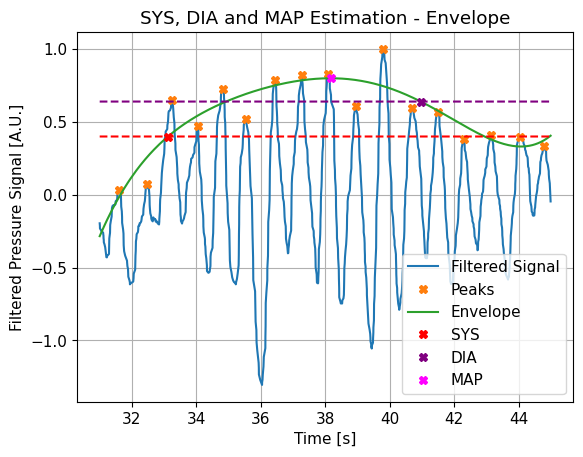

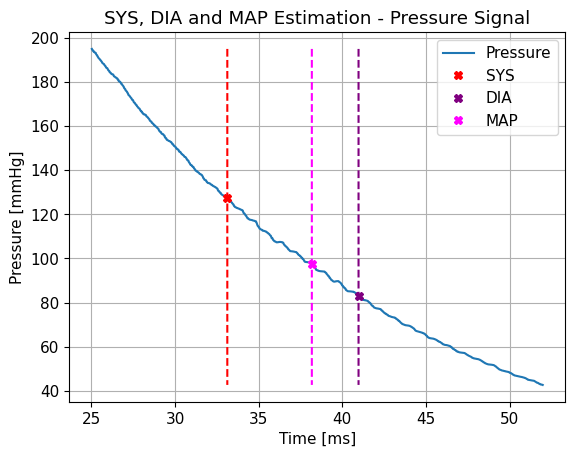

Measured blood pressure is:
SYS: 127
DIA: 83
MAP: 97
HR: 72


In [33]:
# Estimating the SYS and DIA pressure from the signal
bpm_max_peak = max(bpm_envelope)
sys_height = 0.5 * bpm_max_peak
dia_height = 0.8 * bpm_max_peak

bpm_sys_idx = 0
bpm_dia_idx = 0
bpm_sys_time = 0
bpm_dia_time = 0
bpm_closest_dia = 100
bpm_closest_sys = 100

bpm_map_fig = max(bpm_envelope)
bpm_map_time = bpm_analysis_time[bpm_envelope.index(bpm_map_fig)]

for i in range(0, len(bpm_envelope)):
  # We're looking for SYS before MAP
  if bpm_analysis_time[i] < bpm_map_time:
    # Check whether we're closer to the value than the previous one
    if abs(bpm_envelope[i] - sys_height) < bpm_closest_sys:
      bpm_closest_sys = abs(bpm_envelope[i] - sys_height)
      bpm_sys_time = bpm_analysis_time[i]
  else:
    # Do the same thing after MAP for the DIA pressure
    if abs(bpm_envelope[i] - dia_height) < bpm_closest_dia:
      bpm_closest_dia = abs(bpm_envelope[i] - dia_height)
      bpm_dia_time = bpm_analysis_time[i]

bpm_map = 0
#t_bpm_map = bpm_peaks_time[bpm_peaks_data.index(max(bpm_peaks_data))]
t_bpm_map = bpm_analysis_time[bpm_envelope.index(max(bpm_envelope))]

for i in range(0, len(bpm_deflation_time) - 1):
  if bpm_deflation_time[i] <= t_bpm_map and bpm_deflation_time[i + 1] > t_bpm_map:
    bpm_map = bpm_deflation_data[i]
    break

# Figure 6 - Detrended pressure signal with peaks with a fitted envelope signal and lines for the SYS and DIA pressures
fig_bpm6, ax_bpm6 = plt.subplots()
ax_bpm6.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtered Signal')
ax_bpm6.plot(bpm_peaks_time, bpm_peaks_data, 'X', label = 'Peaks')
ax_bpm6.plot(bpm_analysis_time, bpm_envelope, label = 'Envelope')
ax_bpm6.plot(bpm_analysis_time, np.ones(len(bpm_analysis_time)) * sys_height, '--', color = 'red')
ax_bpm6.plot(bpm_analysis_time, np.ones(len(bpm_analysis_time)) * dia_height, '--', color = 'purple')
ax_bpm6.plot(bpm_sys_time, sys_height, 'X', color = 'red', linewidth = 18, label = 'SYS')
ax_bpm6.plot(bpm_dia_time, dia_height, 'X', color = 'purple', linewidth = 18, label = 'DIA')
ax_bpm6.plot(t_bpm_map, max(bpm_envelope), 'X', color = 'magenta', linewidth = 18, label = 'MAP')
ax_bpm6.set(xlabel = 'Time [s]', ylabel = 'Filtered Pressure Signal [A.U.]', title = 'SYS, DIA and MAP Estimation - Envelope')
ax_bpm6.legend(loc = 4)
ax_bpm6.grid(which='both')

# Calculating the actual pressure values by using the time of the previously found signals
bpm_sys_val = 0
bpm_dia_val = 0

for i in range(0, len(bpm_deflation_data) - 1):
  if bpm_deflation_time[i] <= bpm_sys_time and bpm_deflation_time[i + 1] > bpm_sys_time:
    bpm_sys_val = bpm_deflation_data[i]
  if bpm_deflation_time[i] <= bpm_dia_time and bpm_deflation_time[i + 1] > bpm_dia_time:
    bpm_dia_val = bpm_deflation_data[i]

# Figure 7 - Pressure signal with time markers for reading the SYS, DIA and MAP
fig_bpm7, ax_bpm7 = plt.subplots()
ax_bpm7.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pressure')
ax_bpm7.plot(np.ones(len(bpm_deflation_time)) * bpm_sys_time, bpm_deflation_data, '--', color = 'red')
ax_bpm7.plot(np.ones(len(bpm_deflation_time)) * bpm_dia_time, bpm_deflation_data, '--', color = 'purple')
ax_bpm7.plot(np.ones(len(bpm_deflation_time)) * t_bpm_map, bpm_deflation_data, '--', color = 'magenta')
ax_bpm7.plot(bpm_sys_time, bpm_sys_val, 'X', color = 'red', label = 'SYS')
ax_bpm7.plot(bpm_dia_time, bpm_dia_val, 'X', color = 'purple', label = 'DIA')
ax_bpm7.plot(t_bpm_map, bpm_map, 'X', color = 'magenta', label = 'MAP')
ax_bpm7.set(xlabel = 'Time [ms]', ylabel = 'Pressure [mmHg]', title = 'SYS, DIA and MAP Estimation - Pressure Signal')
ax_bpm7.legend()
ax_bpm7.grid(which='both')

plt.show()

print('Measured blood pressure is:')
print('SYS: ' + str(int(bpm_sys_val)))
print('DIA: ' + str(int(bpm_dia_val)))
print('MAP: ' + str(int(bpm_map)))
bpm_hr = 60 * (len(bpm_peaks_data) - 1) / (bpm_peaks_time[-1] - bpm_peaks_time[0])
print('HR: ' + str(int(bpm_hr)))

# **Stethoscope Signal Analysis**

## **Stethoscope Full Duration**

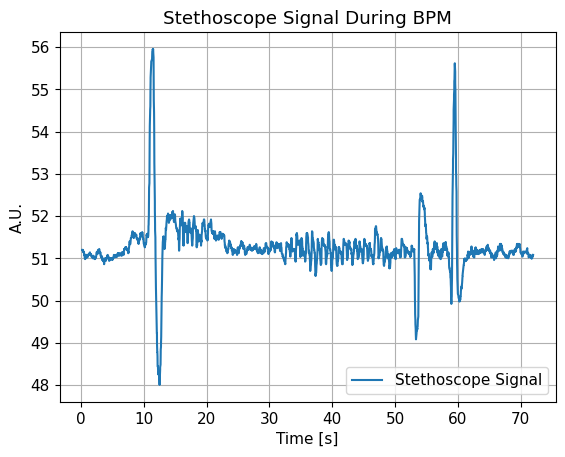

In [34]:
#AUX signal analysis
window_size = 50
aux_filtered_data = []
aux_filtered_time = aux_time[window_size :]

for i in range(window_size, len(aux_raw)):
  aux_filtered_data.append(sum(aux_raw[i : i + window_size]) / window_size)

# Figure 1 - Aux signal during pressure measurement
fig_aux1, ax_aux1 = plt.subplots()
ax_aux1.plot(aux_filtered_time[: -500], aux_filtered_data[: -500], label = 'Stethoscope Signal')
ax_aux1.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'Stethoscope Signal During BPM')
ax_aux1.legend()
ax_aux1.grid(which='both')

## **Stethoscope Deflation Period**

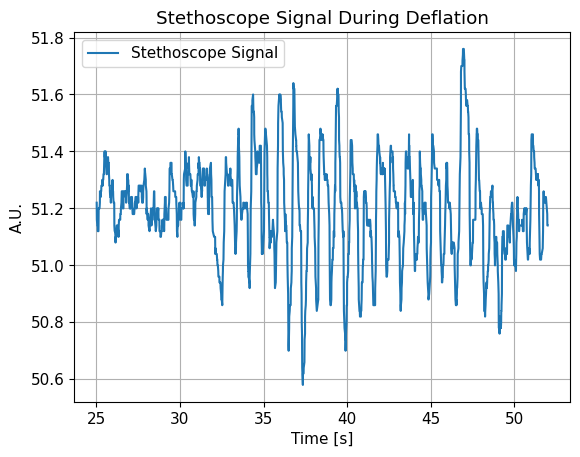

In [35]:
aux_deflation_data = []
aux_deflation_time = []

for i in range(0, len(aux_filtered_data)):
    if aux_filtered_time[i] >= t_deflation_start and aux_filtered_time[i] <= t_deflation_stop:
      aux_deflation_data.append(aux_filtered_data[i])
      aux_deflation_time.append(aux_filtered_time[i])


# Figure 2 - Aux signal during deflation
fig_aux2, ax_aux2 = plt.subplots()
ax_aux2.plot(aux_deflation_time, aux_deflation_data, label = 'Stethoscope Signal')
ax_aux2.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'Stethoscope Signal During Deflation')
ax_aux2.legend()
ax_aux2.grid(which='both')

## **Stethoscope Peak Detection**

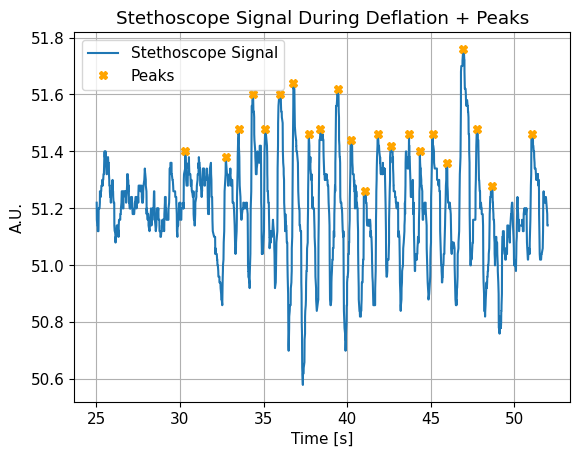

In [36]:
# AUX signal peak detection
aux_peaks_ids, aux_peak_properties = find_peaks(aux_deflation_data, height = 0, distance = 30, prominence = (0.3, None))
# Arrays for storing the peaks
aux_peaks_data = []
aux_peaks_time = []
# Getting the peak data into the arrays
for peak in aux_peaks_ids:
  aux_peaks_data.append(aux_deflation_data[peak])
  aux_peaks_time.append(aux_deflation_time[peak])

# Figure 3 - Aux signal during deflation with peak detection
fig_aux3, ax_aux3 = plt.subplots()
#ax_aux3.set_aspect(2000)
ax_aux3.plot(aux_deflation_time, aux_deflation_data, label = 'Stethoscope Signal')
ax_aux3.plot(aux_peaks_time, aux_peaks_data, 'X', color = 'orange', label = 'Peaks')
ax_aux3.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'Stethoscope Signal During Deflation + Peaks')
ax_aux3.legend()
ax_aux3.grid(which='both')

## **Delta Time Between the Peaks**

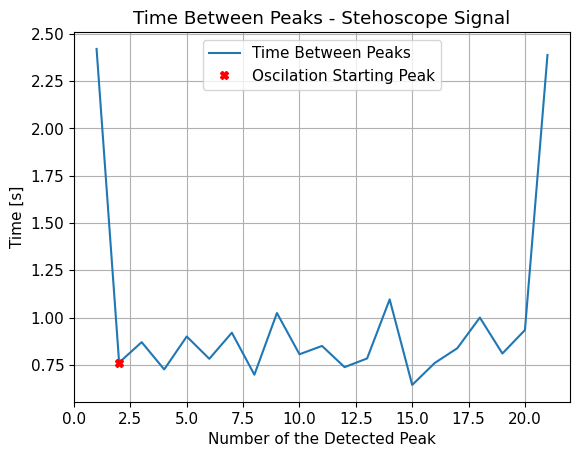

In [37]:
# Calculating the delta time between detected pulses
aux_beats_delta = []

for i in range(1, len(aux_peaks_data)):
  aux_beats_delta.append(aux_peaks_time[i] - aux_peaks_time[i - 1])

# Figure 4 - Time between consecutive pulses (peaks)
fig_aux4, ax_aux4 = plt.subplots()
ax_aux4.plot(np.linspace(start = 1, stop = len(aux_beats_delta), num = len(aux_beats_delta)), aux_beats_delta, label = 'Time Between Peaks')
ax_aux4.plot(2, aux_beats_delta[1], 'X', color = 'red', label = 'Oscilation Starting Peak')
ax_aux4.set(xlabel = 'Number of the Detected Peak', ylabel = 'Time [s]', title = 'Time Between Peaks - Stehoscope Signal')
ax_aux4.legend()
ax_aux4.grid(which='both')

## **Rough SYS Pressure Estimation Using the Stethoscope Signal**

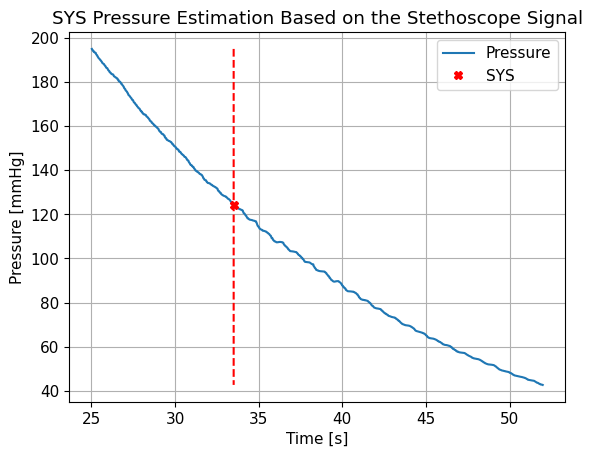

AUX signal results
AUX HR measured during deflation: 71
AUX SYS pressure measurement: 124


In [38]:
# Calculating the SYS pressure based on the AUX signal
aux_sys = 0
for i in range(0, len(bpm_deflation_data) - 1):
  if bpm_deflation_time[i] <= aux_peaks_time[2] and bpm_deflation_time[i + 1] > aux_peaks_time[2]:
    aux_sys = bpm_deflation_data[i]

# Figure 5 - Finding the SYS pressure based on the AUX signal
fig_aux5, ax_aux5 = plt.subplots()
ax_aux5.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pressure')
ax_aux5.plot(np.ones(len(bpm_deflation_time)) * aux_peaks_time[2], bpm_deflation_data, '--', color = 'red')
ax_aux5.plot(aux_peaks_time[2], aux_sys, 'X', color = 'red', label = 'SYS')
ax_aux5.set(xlabel = 'Time [s]', ylabel = 'Pressure [mmHg]', title = 'SYS Pressure Estimation Based on the Stethoscope Signal')
ax_aux5.legend()
ax_aux5.grid(which='both')

plt.show()

# Print out the PPG peaks location
#t_dia_ppg = ppg_peaks_time[0]
hr_aux = 60 * (len(aux_peaks_data) - 4) / (aux_peaks_time[-2] - aux_peaks_time[2])

# Print out the results
print('AUX signal results')
#print('PPG DIA detected at time: ' + str(t_dia_ppg))
print('AUX HR measured during deflation: ' + str(int(hr_aux)))
print('AUX SYS pressure measurement: ' + str(int(aux_sys)))

# **PPG Signal Analysis**

## **PPG Full Duration**

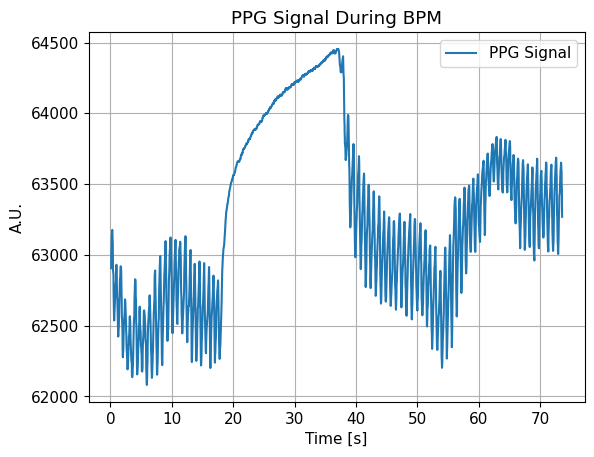

In [39]:
# There are PPG values that repeat both in time and value, using the ppg_time as guidance, delete the doubles
ppg_filtered_data1 = []
ppg_filtered_time1 = []

for i in range(0, len(ppg_raw) - 1):
  # Add the first elements to the array as well as all other first appearences
  if i == 0 or ppg_time[i] != ppg_filtered_time1[-1]:
    ppg_filtered_data1.append(ppg_raw[i])
    ppg_filtered_time1.append(ppg_time[i])

window_size = 20
ppg_filtered_data = []
ppg_filtered_time = ppg_filtered_time1[window_size :]

for i in range(window_size, len(ppg_filtered_data1)):
  ppg_filtered_data.append(sum(ppg_filtered_data1[i : i + window_size]) / window_size)

ppg_filtered_data = ppg_filtered_data[: -300]
ppg_filtered_time = ppg_filtered_time[: -300]

# Figure 1 - PPG signal during the BPM routine
fig_ppg1, ax_ppg1 = plt.subplots()
ax_ppg1.plot(ppg_filtered_time, ppg_filtered_data, label = 'PPG Signal')
ax_ppg1.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'PPG Signal During BPM')
ax_ppg1.legend()
ax_ppg1.grid(which='both')

## **PPG Signal Deflation**

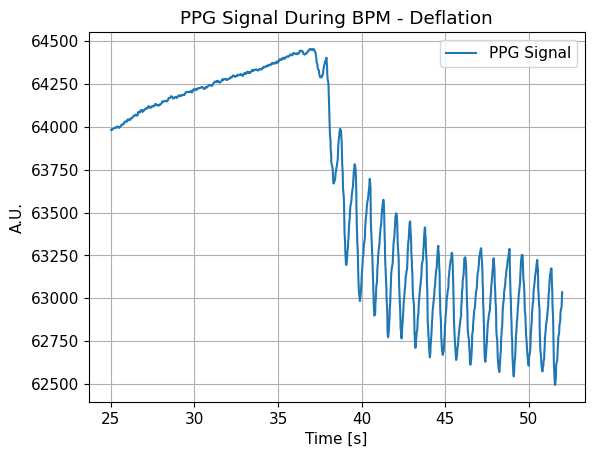

In [40]:
#PPG signal analysis during the cuff deflation
ppg_deflation_data = []
ppg_deflation_time = []
for i in range(0, len(ppg_filtered_data)):
    if ppg_filtered_time[i] >= t_deflation_start and ppg_filtered_time[i] <= t_deflation_stop:
      ppg_deflation_data.append(ppg_filtered_data[i])
      ppg_deflation_time.append(ppg_filtered_time[i])

# Figure 2 - PPG signal during the CUFF deflation
fig_ppg2, ax_ppg2 = plt.subplots()
ax_ppg2.plot(ppg_deflation_time, ppg_deflation_data, label = 'PPG Signal')
ax_ppg2.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'PPG Signal During BPM - Deflation')
ax_ppg2.legend()
ax_ppg2.grid(which='both')

## **Detrending the PPG Data**

/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/obspy/signal/detrend.py:110: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyval(np.polyfit(x, data, deg=order), x)


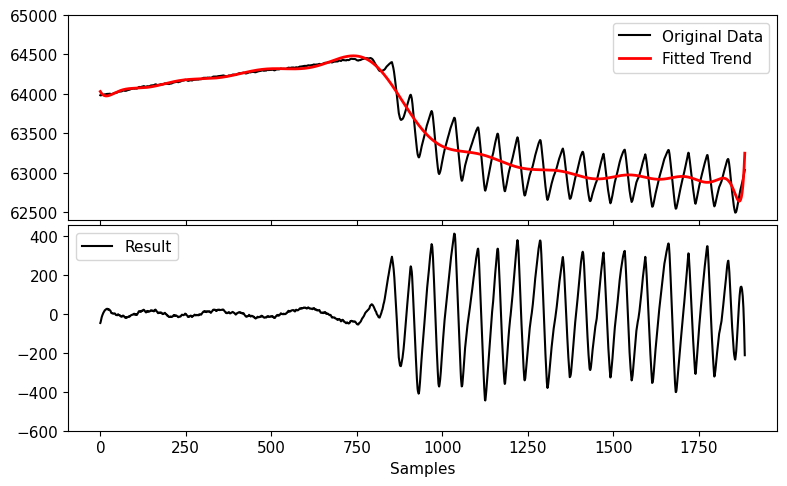

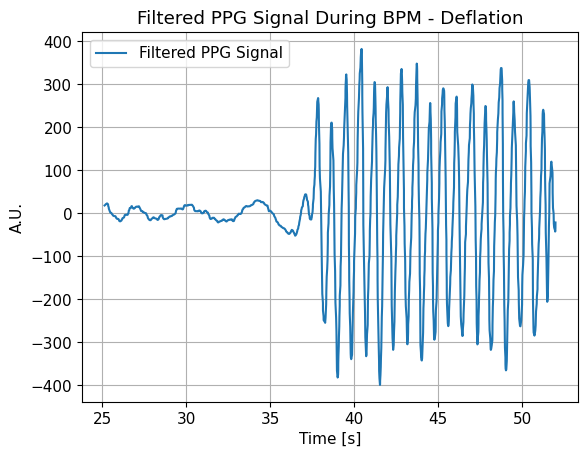

In [41]:
# Detrending the PPG function
ppg_obspy_data = obspy.read()[0].filter('highpass', freq = 1)
ppg_obspy_data.data = np.array(ppg_deflation_data)
ppg_detrended_function = polynomial(ppg_obspy_data.data, order = 50, plot = True)

# Additional data filtering
window_size = 10
ppg_detrented_filtered_data = []
ppg_detrented_filtered_time = ppg_deflation_time[window_size :]
for i in range(window_size, len(ppg_detrended_function)):
  ppg_detrented_filtered_data.append(sum(ppg_detrended_function[i : i + window_size]) / window_size)

# Figure 3 - Detrended PPG signal during cuff deflation
fig_ppg3, ax_ppg3 = plt.subplots()
#ax_ppg3.set_aspect(15)
ax_ppg3.plot(ppg_detrented_filtered_time, ppg_detrented_filtered_data, label = 'Filtered PPG Signal')
ax_ppg3.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'Filtered PPG Signal During BPM - Deflation')
ax_ppg3.legend()
ax_ppg3.grid(which='both')

## **PPG Peak Detection**

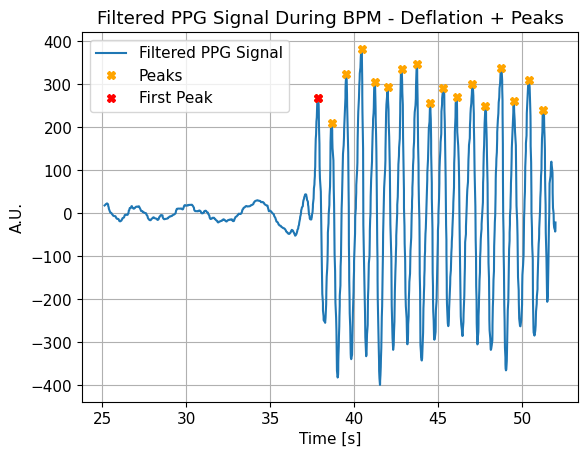

In [42]:
# Peak detection of the PPG signal
ppg_peaks_ids, ppg_peak_properties = find_peaks(ppg_detrented_filtered_data, height = 0, distance = 30, prominence = (200, None))
ppg_peaks_data = []
ppg_peaks_time = []
for peak in ppg_peaks_ids:
  ppg_peaks_data.append(ppg_detrented_filtered_data[peak])
  ppg_peaks_time.append(ppg_detrented_filtered_time[peak])

# Figure 4 - Detrended PPG signal during cuff deflation with Peaks
fig_ppg4, ax_ppg4 = plt.subplots()
#ax_ppg4.set_aspect(15)
ax_ppg4.plot(ppg_detrented_filtered_time, ppg_detrented_filtered_data, label = 'Filtered PPG Signal')
ax_ppg4.plot(ppg_peaks_time, ppg_peaks_data, 'X', label = 'Peaks', color = 'orange')
ax_ppg4.plot(ppg_peaks_time[0], ppg_peaks_data[0], 'X', linewidth = 5, color = 'red', label = 'First Peak')
ax_ppg4.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'Filtered PPG Signal During BPM - Deflation + Peaks')
ax_ppg4.legend()
ax_ppg4.grid(which='both')

## **Estimating the DIA Pressure Based on the PPG Signal**

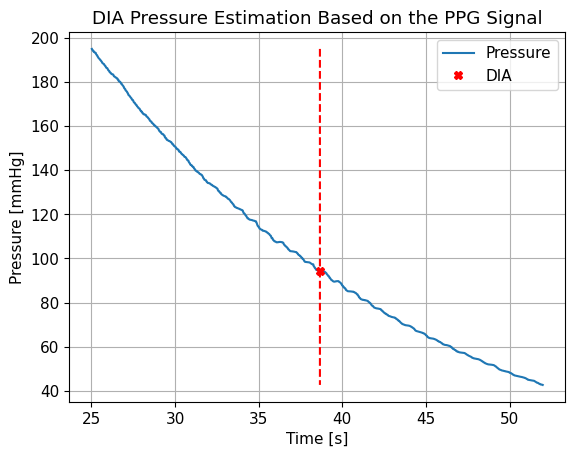

PPG signal results
PPG HR measured during deflation: 71
PPG DIA pressure measurement: 94


In [43]:
# Calculating the DIA pressure from the PPG signal
t_dia_ppg = ppg_peaks_time[1]
ppg_dia = 0
for i in range(0, len(bpm_deflation_data) - 1):
  if bpm_deflation_time[i] <= t_dia_ppg and bpm_deflation_time[i + 1] > t_dia_ppg:
    ppg_dia = bpm_deflation_data[i]

# Figure 5 - Showing the DIA pressure from the PPG signal
fig_ppg5, ax_ppg5 = plt.subplots()
ax_ppg5.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pressure')
ax_ppg5.plot(np.ones(len(bpm_deflation_time)) * t_dia_ppg, bpm_deflation_data, '--', color = 'red')
ax_ppg5.plot(t_dia_ppg, ppg_dia, 'X', color = 'red', label = 'DIA')
ax_ppg5.set(xlabel = 'Time [s]', ylabel = 'Pressure [mmHg]', title = 'DIA Pressure Estimation Based on the PPG Signal')
ax_ppg5.legend()
ax_ppg5.grid(which='both')


plt.show()


# Print out the PPG peaks location
t_dia_ppg = ppg_peaks_time[0]
hr_ppg = 60 * (len(ppg_peaks_data) - 1) / (ppg_peaks_time[-1] - ppg_peaks_time[0])

# Print out the results
print('PPG signal results')
#print('PPG DIA detected at time: ' + str(t_dia_ppg))
print('PPG HR measured during deflation: ' + str(int(hr_ppg)))
print('PPG DIA pressure measurement: ' + str(int(ppg_dia)))

# **ECG Data Analysis**

## **ECG Full Duration**

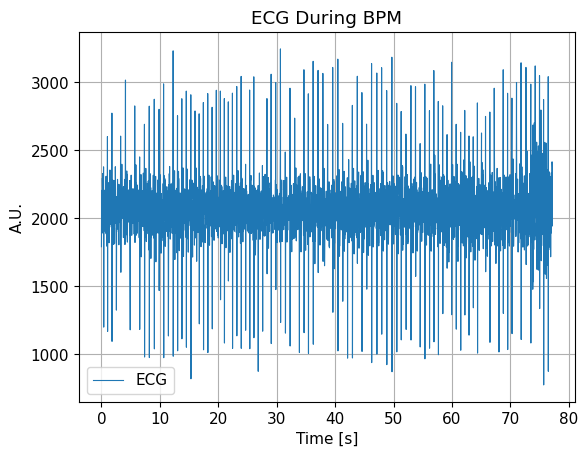

In [44]:
# ECG
# Fitlering the ECG data
window_size = 1
ecg_filtered_data = []
ecg_filtered_time = ecg_time[window_size :]
for i in range(window_size, len(ecg_raw)):
  ecg_filtered_data.append(sum(ecg_raw[i : i + window_size]) / window_size)
ecg_filtered_data = ecg_filtered_data[: -100]
ecg_filtered_time = ecg_filtered_time[: -100]

# Figure 1 - ECG data throghout the whole BPM
fig_ecg1, ax_ecg1 = plt.subplots()
#ax_ecg1.set_aspect(20)
ax_ecg1.plot(ecg_filtered_time, ecg_filtered_data, linewidth = 0.8, label = 'ECG')
ax_ecg1.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'ECG During BPM')
ax_ecg1.legend()
ax_ecg1.grid(which='both')

## **Analyzing a Part of the ECG Data**

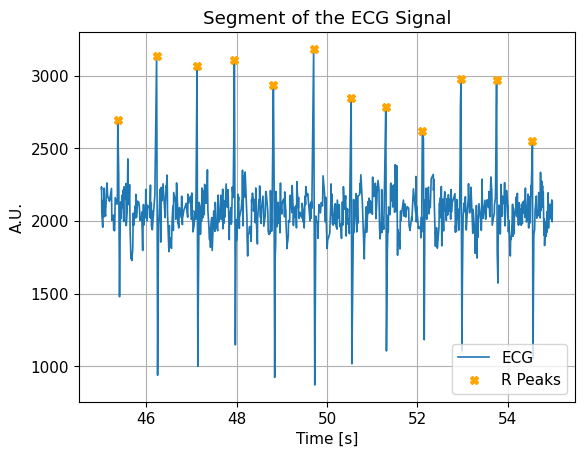

In [45]:
# Extracing a piece of data for analysis
ecg_analysis_start  = 45
ecg_analysis_stop   = 55
ecg_analysis_data   = []
ecg_analysis_time   = []
for i in range(0, len(ecg_filtered_data)):
  if ecg_filtered_time[i] >= ecg_analysis_start and ecg_filtered_time[i] <= ecg_analysis_stop:
    ecg_analysis_data.append(ecg_filtered_data[i])
    ecg_analysis_time.append(ecg_filtered_time[i])

# Peak detection of the ECG signal
ecg_peaks_ids, ecg_peak_properties = find_peaks(ecg_analysis_data, height = 0, distance = 40, prominence = (500, None))
ecg_peaks_data = []
ecg_peaks_time = []
for peak in ecg_peaks_ids:
  ecg_peaks_data.append(ecg_analysis_data[peak])
  ecg_peaks_time.append(ecg_analysis_time[peak])

# Figure 2 - Part of ECG Data
fig_ecg2, ax_ecg2 = plt.subplots()
#ax_ecg2.set_aspect(6)
ax_ecg2.plot(ecg_analysis_time, ecg_analysis_data, linewidth = 1.2, label = 'ECG')
ax_ecg2.plot(ecg_peaks_time, ecg_peaks_data, 'X', linewidth = 1, color = 'orange', label = 'R Peaks')
ax_ecg2.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'Segment of the ECG Signal')
ax_ecg2.legend()
ax_ecg2.grid(which='both')

## **Heart Rate Variability**

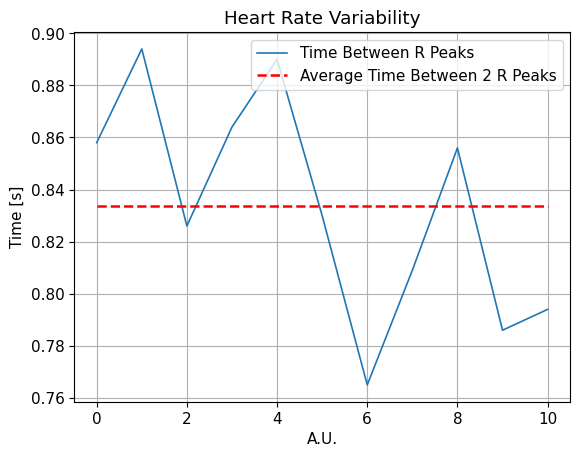

In [46]:
# Calculating the delta time between R peaks
ecg_time_deltas = []
for i in range(1, len(ecg_peaks_time)):
  ecg_time_deltas.append(ecg_peaks_time[i] - ecg_peaks_time[i - 1])
mean_pulse_time = sum(ecg_time_deltas) / len(ecg_time_deltas)

# Figure 3 - HRV
fig_ecg3, ax_ecg3 = plt.subplots()
#ax_ecg3.set_aspect(10)
ax_ecg3.plot(ecg_time_deltas, linewidth = 1.2, label = 'Time Between R Peaks')
ax_ecg3.plot(np.linspace(0, len(ecg_time_deltas) - 1, len(ecg_time_deltas)), np.ones(len(ecg_time_deltas)) * mean_pulse_time, '--', color = 'red', linewidth = 1.8, label = 'Average Time Between 2 R Peaks')
ax_ecg3.set(xlabel = 'A.U.', ylabel = 'Time [s]', title = 'Heart Rate Variability')
ax_ecg3.legend()
ax_ecg3.grid(which='both')

## **Single Heart Beat From ECG**

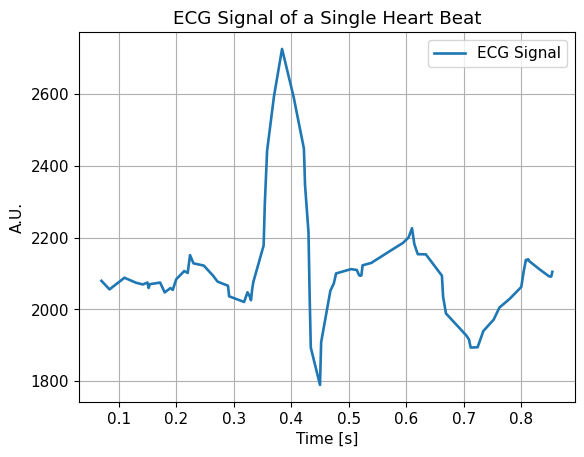

Heart rate calculated based on the ECG is: 71.95813344962933


In [47]:
# Extracting a single heart beat out of the signal
ecg_beat_start  = 47.5
ecg_beat_stop   = 48.5
ecg_single_data   = []
ecg_single_time   = []
for i in range(0, len(ecg_analysis_data)):
  if ecg_analysis_time[i] >= ecg_beat_start and ecg_analysis_time[i] <= ecg_beat_stop:
    ecg_single_data.append(ecg_analysis_data[i])
    ecg_single_time.append(ecg_analysis_time[i])
    if len(ecg_single_time) > 1:
      ecg_single_time[-1] -= ecg_single_time[0]
ecg_single_time[0] = 0

# Additional Filtering
window_size = 7
ecg_single_filtered_data = []
ecg_single_filtered_time = ecg_single_time[window_size :]
for i in range(window_size, len(ecg_single_data)):
  ecg_single_filtered_data.append(sum(ecg_single_data[i : i + window_size]) / window_size)
ecg_single_filtered_data = ecg_single_filtered_data[: -10]
ecg_single_filtered_time = ecg_single_filtered_time[: -10]

# Figure 4 - Single Heartbeat
fig_ecg4, ax_ecg4 = plt.subplots()
#ax_ecg4.set_aspect(1)
ax_ecg4.plot(ecg_single_filtered_time, ecg_single_filtered_data, linewidth = 1.9, label = 'ECG Signal')
ax_ecg4.set(xlabel = 'Time [s]', ylabel = 'A.U.', title = 'ECG Signal of a Single Heart Beat')
ax_ecg4.legend()
ax_ecg4.grid(which='both')

plt.show()

# Calculating the HR
hr_ecg = 60 * (len(ecg_peaks_data) - 1) / (ecg_peaks_time[-1] - ecg_peaks_time[0])
print('Heart rate calculated based on the ECG is: ' + str(hr_ecg))

# **Final Results**

In [48]:
# This code serves just to print out all of the results

# BPM
print('BPM results using only the pressure sensor:')
print('SYS pressure:        ' + str(bpm_sys_val))
print('DIA pressure:        ' + str(bpm_dia_val))
print('MAP:                 ' + str(bpm_map))

print('--------------------------------------------------------------')

# Pressure + AUX + PPG
print('BPM results using pressure, PPG and AUX measurements:')
print('SYS pressure (AUX):  ' + str(aux_sys))
print('DIA pressure (PPG):  ' + str(ppg_dia ))

print('--------------------------------------------------------------')

print('Heart rate results from different measurements')
print('Heart rate BPM:      ' + str(bpm_hr))
print('Heart rate PPG:      ' + str(hr_ppg))
print('Heart rate AUX:      ' + str(hr_aux))
print('Heart rate ECG:      ' + str(hr_ecg))

BPM results using only the pressure sensor:
SYS pressure:        127.43381714285712
DIA pressure:        83.05209142857143
MAP:                 97.54287314285715
--------------------------------------------------------------
BPM results using pressure, PPG and AUX measurements:
SYS pressure (AUX):  124.25757485714283
DIA pressure (PPG):  94.27657142857147
--------------------------------------------------------------
Heart rate results from different measurements
Heart rate BPM:      72.88187063467961
Heart rate PPG:      71.6364450414148
Heart rate AUX:      71.14624505928853
Heart rate ECG:      71.95813344962933


# **Downloading All of the Figures**

In [49]:
# BPM Figures
fig_bpm1.savefig("BPM_fig1_Air Pressure Inside the Cuff During BPM.png", dpi = 250, bbox_inches='tight')
fig_bpm2.savefig("BPM_fig2_Air Pressure Inside the Cuff During BPM - Deflation.png", dpi = 250, bbox_inches='tight')
fig_bpm3.savefig("BPM_fig3_Filtered Air Pressure Inside the Cuff During Deflation.png", dpi = 250, bbox_inches='tight')
fig_bpm4.savefig("BPM_fig4_Filtered Air Pressure Inside the Cuff During Deflation + Peaks.png", dpi = 250, bbox_inches='tight')
fig_bpm5.savefig("BPM_fig5_Envelope Estimation on the Pressure Signal.png", dpi = 250, bbox_inches='tight')
fig_bpm6.savefig("BPM_fig6_SYS, DIA and MAP Estimation - Envelope.png", dpi = 250, bbox_inches='tight')
fig_bpm7.savefig("BPM_fig7_SYS, DIA and MAP Estimation - Pressure Signal.png", dpi = 250, bbox_inches='tight')
# Stethoscope Figures
fig_aux1.savefig("AUX_fig1_Stethoscope Signal During BPM.png", dpi = 250, bbox_inches='tight')
fig_aux2.savefig("AUX_fig2_Stethoscope Signal During BPM - Deflation.png", dpi = 250, bbox_inches='tight')
fig_aux3.savefig("AUX_fig3_Stethoscope Signal During BPM - Deflation + Peaks.png", dpi = 250, bbox_inches='tight')
fig_aux4.savefig("AUX_fig4_Time Between Peaks - Stehoscope Signal.png", dpi = 250, bbox_inches='tight')
fig_aux5.savefig("AUX_fig5_SYS Pressure Estimation Based on the Stethoscope Signal.png", dpi = 250, bbox_inches='tight')
# PPG Figures
fig_ppg1.savefig("PPG_fig1_PPG Signal During BPM.png", dpi = 250, bbox_inches='tight')
fig_ppg2.savefig("PPG_fig2_PPG Signal During BPM - Deflation.png", dpi = 250, bbox_inches='tight')
fig_ppg3.savefig("PPG_fig3_Filtered PPG Signal During BPM - Deflation.png", dpi = 250, bbox_inches='tight')
fig_ppg4.savefig("PPG_fig4_Filtered PPG Signal During BPM - Deflation + Peaks.png", dpi = 250, bbox_inches='tight')
fig_ppg5.savefig("PPG_fig5_DIA Pressure Estimation Based on the PPG Signal.png", dpi = 250, bbox_inches='tight')
# ECG Figures
fig_ecg1.savefig("ECG_fig1_ECG During BPM.png", dpi = 250, bbox_inches='tight')
fig_ecg2.savefig("ECG_fig2_Segment of the ECG Signal.png", dpi = 250, bbox_inches='tight')
fig_ecg3.savefig("ECG_fig3_Heart Rate Variability.png", dpi = 250, bbox_inches='tight')
fig_ecg4.savefig("ECG_fig4_ECG Signal of a Single Heart Beat.png", dpi = 250, bbox_inches='tight')